In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
from inference_interface import template_to_multihist, multihist_to_template
import scipy.stats as stats
from appletree.utils import load_json
from light_wimp_data_release import Template

XLA_PYTHON_CLIENT_PREALLOCATE is set to false
XLA_PYTHON_CLIENT_ALLOCATOR is set to platform


/home/yuanlq/.local/lib/python3.9/site-packages/appletree/__init__.py:51: UserWarning: You are running appletree on CPU, which usually results in low performance.
  warn(warning)


Using aptext package from https://github.com/XENONnT/applefiles


# 1. Make template for a 6 GeV WIMP with analysis yield model

In [2]:
# Initalize fast simulation object
template = Template()

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [3]:
# Load yield model curve
path = '../light_wimp_data_release/data/'
yield_model = {
    'ly': load_json(path + "signal/nr_ly_ybe_only_median_sr0_cevns.json"),
    'qy': load_json(path + "signal/nr_qy_ybe_only_median_sr0_cevns.json")
}

In [4]:
# Load analytically computed spectrum
wimp_spectrum = load_json(path + f"signal/wimp_si_spectrum_6.json")

In [5]:
# Perform fast simulation
wimp_template = template.build_template(wimp_spectrum, yield_model)

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13465 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13529 [00:00<?, ?it/s]

In [6]:
# Load officlal template used in the analysis
template_6geV = dict()
for sr in ['sr0', 'sr1']:
    template_6geV[sr] = template_to_multihist(path + f'wimp_si/template_XENONnT_{sr}_wimp_si_6_cevns_tly_0.0_tqy_0.0.h5')['template']

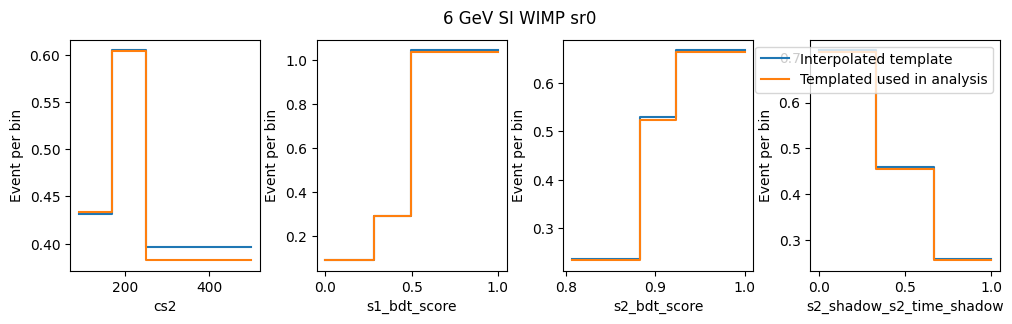

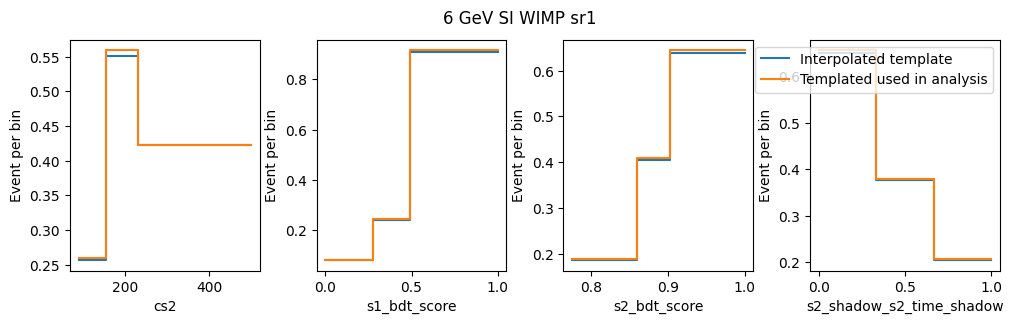

In [7]:
# Compared data released templates

for sr in ['sr0', 'sr1']:

    fig = plt.figure(figsize=(12, 3))
    grid = plt.GridSpec(1, 4, wspace=0.3)
    
    for i, axis in enumerate(['cs2', 's1_bdt_score', 's2_bdt_score', "s2_shadow_s2_time_shadow"]):
    
        plt.subplot(grid[i])
        
        wimp_template[sr].project(axis=axis).plot(label='Interpolated template',)
        template_6geV[sr].project(axis=axis).plot(label='Templated used in analysis')
        plt.xlabel(axis)
        plt.ylabel('Event per bin')

    plt.legend(loc=1)
    fig.suptitle(f'6 GeV SI WIMP {sr}')
    plt.show()

# 2. Make template for a custom signal model using a custom yield model

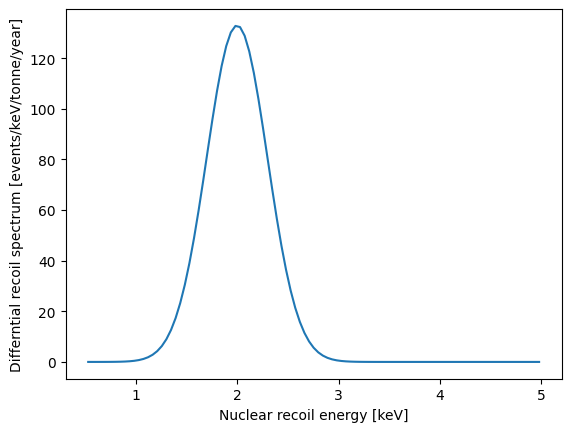

In [8]:
# Signal spectrum, let's assume a mono-energetic line at 2 keV

ek = np.linspace(0.51, 5, 100)
ek_bin_center = (ek[1:] + ek[:-1]) / 2
ek_bin_width = np.diff(ek_bin_center)[0]

mu, sigma = 2, 0.3
rate = 100
dr_dek = stats.norm.pdf(ek_bin_center, mu, sigma)

cdf = np.cumsum(ek_bin_width * dr_dek)

plt.plot(ek_bin_center, dr_dek / cdf[-1] * rate)
plt.xlabel('Nuclear recoil energy [keV]')
plt.ylabel('Differntial recoil spectrum [events/keV/tonne/year]')
plt.show()


# Then the file we input is:
custom_spectrum = dict()
custom_spectrum['coordinate_system'] = [0.0] + (cdf / cdf[-1]).tolist()
custom_spectrum['coordinate_name'] = 'cdf'
custom_spectrum['map'] = ek.tolist()
custom_spectrum['rate'] = rate

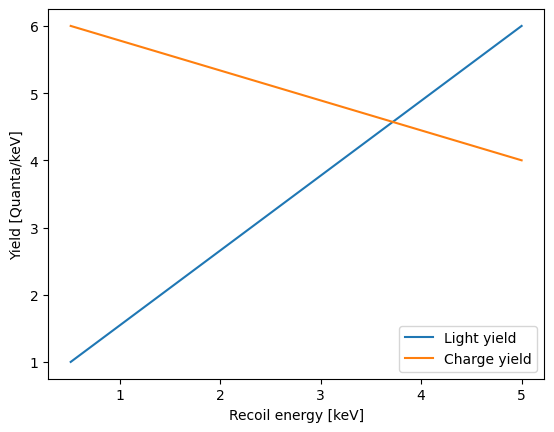

In [9]:
# Let's assume simple LY and QY curve for simplicity, note the ly and qy cannot excced interpolation bounds!

custom_yield_model = dict()
custom_yield_model['ly'] = dict(coordinate_system = np.linspace(0.51, 5, 100).tolist(),
                                map = np.linspace(1, 6, 100).tolist())
custom_yield_model['qy'] = dict(coordinate_system = np.linspace(0.51, 5, 100).tolist(),
                                map = np.linspace(6, 4, 100).tolist())

plt.plot(custom_yield_model['ly']['coordinate_system'],custom_yield_model['ly']['map'], label='Light yield')
plt.plot(custom_yield_model['qy']['coordinate_system'],custom_yield_model['qy']['map'], label='Charge yield')
plt.xlabel('Recoil energy [keV]')
plt.ylabel('Yield [Quanta/keV]')
plt.legend()
plt.show()


In [10]:
# Build templates
custom_template = template.build_template(custom_spectrum, custom_yield_model)

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/20000 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/20000 [00:00<?, ?it/s]

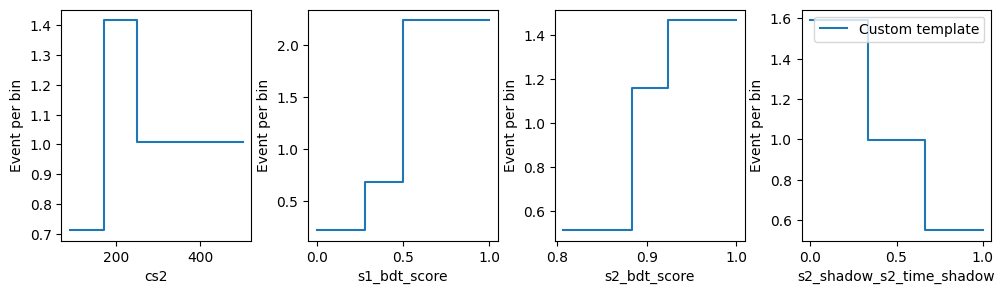

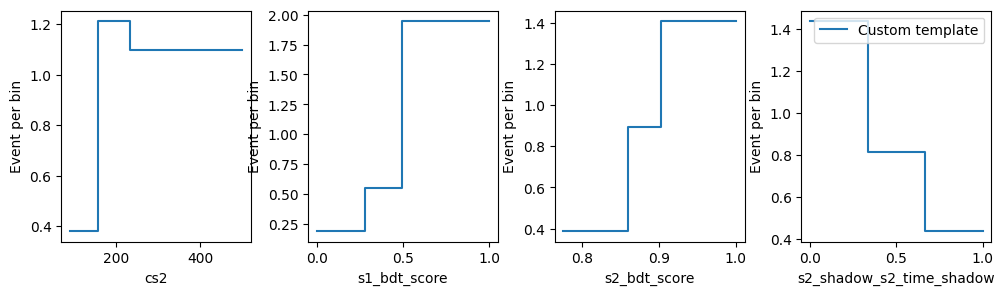

In [11]:
# Plot templates

for sr in ['sr0', 'sr1']:

    fig = plt.figure(figsize=(12, 3))
    grid = plt.GridSpec(1, 4, wspace=0.3)
    
    for i, axis in enumerate(['cs2', 's1_bdt_score', 's2_bdt_score', "s2_shadow_s2_time_shadow"]):
    
        plt.subplot(grid[i])
        
        custom_template[sr].project(axis=axis).plot(label='Custom template',)
        plt.xlabel(axis)
        plt.ylabel('Event per bin')

    plt.legend(loc=1)
    plt.show()

In [12]:
# Now you have the tools to generate any signal with any of signal of interest spectrum and yield model in your mind!
# If you feel like using XENONnT default yield model, it's easier

In [15]:
# Build templates
custom_template = template.build_template(custom_spectrum, yield_model=None)

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/20000 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/20000 [00:00<?, ?it/s]

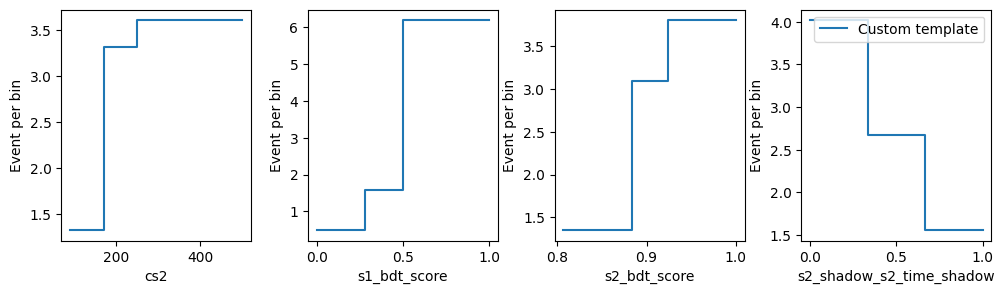

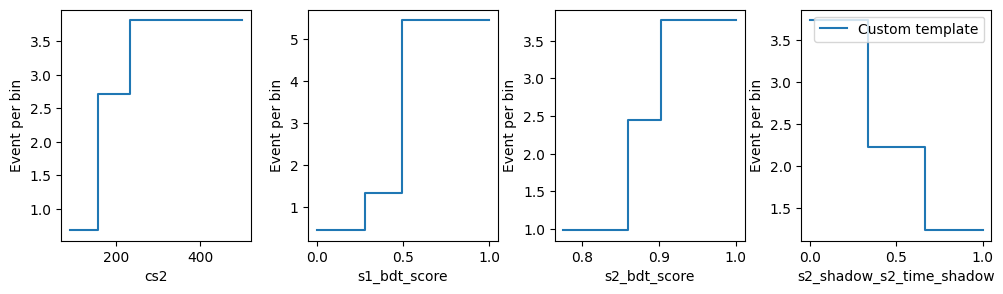

In [16]:
# Plot templates

for sr in ['sr0', 'sr1']:

    fig = plt.figure(figsize=(12, 3))
    grid = plt.GridSpec(1, 4, wspace=0.3)
    
    for i, axis in enumerate(['cs2', 's1_bdt_score', 's2_bdt_score', "s2_shadow_s2_time_shadow"]):
    
        plt.subplot(grid[i])
        
        custom_template[sr].project(axis=axis).plot(label='Custom template',)
        plt.xlabel(axis)
        plt.ylabel('Event per bin')

    plt.legend(loc=1)
    plt.show()

# 3. Example 

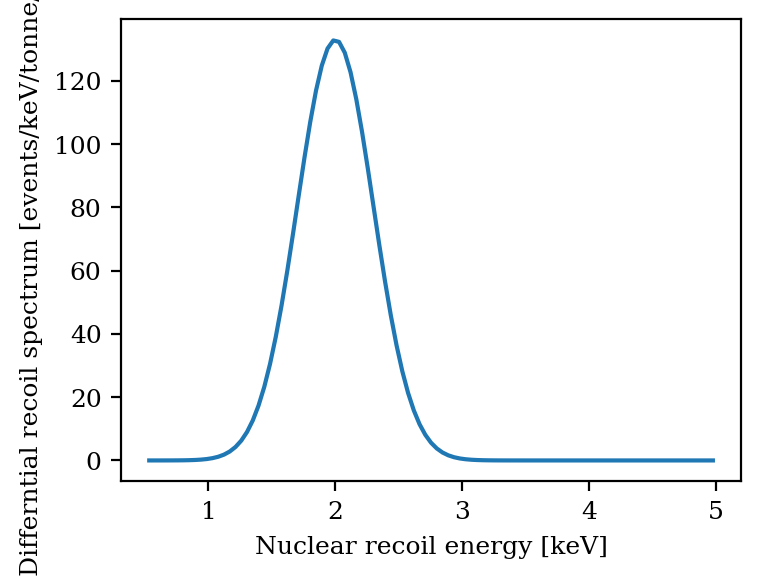

In [27]:
# Signal spectrum, let's assume a mono-energetic line at 2 keV

ek = np.linspace(0.51, 5, 100)
ek_bin_center = (ek[1:] + ek[:-1]) / 2
ek_bin_width = np.diff(ek_bin_center)[0]

mu, sigma = 2, 0.3
rate = 100
dr_dek = stats.norm.pdf(ek_bin_center, mu, sigma)

cdf = np.cumsum(ek_bin_width * dr_dek)

plt.plot(ek_bin_center, dr_dek / cdf[-1] * rate)
plt.xlabel('Nuclear recoil energy [keV]')
plt.ylabel('Differntial recoil spectrum [events/keV/tonne/year]')
plt.show()


# Then the file we input is:
custom_spectrum = dict()
custom_spectrum['coordinate_system'] = [0.0] + (cdf / cdf[-1]).tolist()
custom_spectrum['coordinate_name'] = 'cdf'
custom_spectrum['map'] = ek.tolist()
custom_spectrum['rate'] = rate

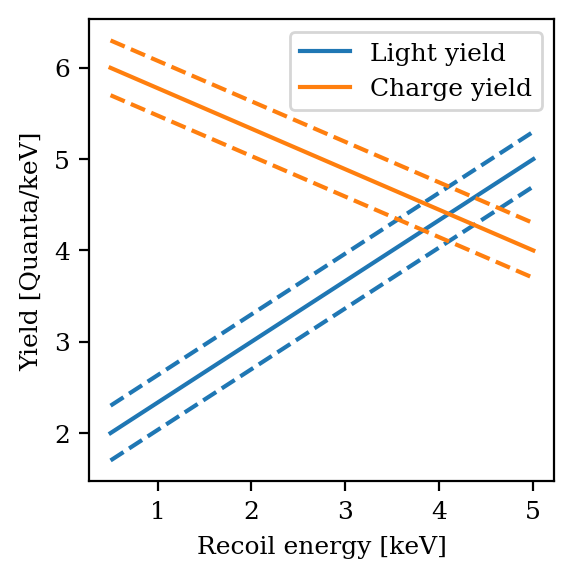

In [61]:
# Let's assume simple LY and QY curve for simplicity, note the ly and qy cannot excced interpolation bounds!

custom_yield_model = dict()
custom_yield_model['ly'] = dict(coordinate_system = np.linspace(0.5, 5, 100).tolist(),
                                map = np.linspace(2, 5, 100).tolist())
custom_yield_model['qy'] = dict(coordinate_system = np.linspace(0.5, 5, 100).tolist(),
                                map = np.linspace(6, 4, 100).tolist())

plt.figure(figsize=(3,3))
plt.plot(custom_yield_model['ly']['coordinate_system'],custom_yield_model['ly']['map'], label='Light yield')
plt.plot(custom_yield_model['ly']['coordinate_system'],np.array(custom_yield_model['ly']['map'])+0.3, 
         color="tab:blue", ls="--")
plt.plot(custom_yield_model['ly']['coordinate_system'],np.array(custom_yield_model['ly']['map'])-0.3, 
         color="tab:blue", ls="--")

plt.plot(custom_yield_model['qy']['coordinate_system'],custom_yield_model['qy']['map'], label='Charge yield')
plt.plot(custom_yield_model['qy']['coordinate_system'],np.array(custom_yield_model['qy']['map'])+0.3,
         color="tab:orange", ls="--")
plt.plot(custom_yield_model['qy']['coordinate_system'],np.array(custom_yield_model['qy']['map'])-0.3,
         color="tab:orange", ls="--")

plt.xlabel('Recoil energy [keV]')
plt.ylabel('Yield [Quanta/keV]')
plt.legend()
#plt.show()
plt.savefig("toy_yield_model.svg")


In [29]:
# Build templates for DM
nominal_ly = np.linspace(2, 5, 100)
nominal_qy = np.linspace(6, 4, 100)
for tly in [-3, -2, -1, 0, 1, 2, 3]:
    for tqy in [-3, -2, -1, 0, 1, 2, 3]:
        _custom_yield_model = dict()
        # Example uncertainty: 0.5 quanta/kev
        _ly = nominal_ly + tly * 0.3
        _qy = nominal_qy + tqy * 0.3
        _custom_yield_model['ly'] = dict(coordinate_system = np.linspace(0.5, 5, 100).tolist(),
                                        map = _ly.tolist())
        _custom_yield_model['qy'] = dict(coordinate_system = np.linspace(0.5, 5, 100).tolist(),
                                        map = _qy.tolist())
        _custom_template = template.build_template(wimp_spectrum, _custom_yield_model)
        
        for sr in ['sr0', 'sr1']:
            fn = f"../light_wimp_data_release/data/generated_dm/template_XENONnT_{sr}_fermionic_dm_6_tly_{tly}.0_tqy_{tqy}.0.h5" 
            multihist_to_template([_custom_template[sr]], fn, ['template'])

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13403 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13495 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13518 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13616 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13550 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13572 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13567 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13614 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13610 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13525 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13578 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13545 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13487 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13462 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13589 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13579 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13609 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13681 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13501 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13646 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13557 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13608 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13569 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13532 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13650 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13628 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13553 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13641 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13503 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13529 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13620 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13582 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13470 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13417 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13597 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13565 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13549 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13516 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13502 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13530 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13587 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13544 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13489 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13585 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13536 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13551 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13559 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13572 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13536 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13581 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13456 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13622 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13580 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13579 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13557 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13681 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13465 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13476 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13541 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13643 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13647 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13443 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13578 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13560 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13623 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13740 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13575 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13660 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13676 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13533 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13666 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13476 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13518 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13604 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13636 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13560 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13463 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13538 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13514 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13485 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13566 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13462 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13479 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13589 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13611 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13544 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13703 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13565 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13566 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13532 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13505 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13663 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13474 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13486 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13514 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13530 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13724 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13522 [00:00<?, ?it/s]

In [30]:
# Build templates for B8
cevns_spectrum = load_json(path+"/signal/cevns_spectrum.json")

for tly in [-3, -2, -1, 0, 1, 2, 3]:
    for tqy in [-3, -2, -1, 0, 1, 2, 3]:
        _custom_yield_model = dict()
        # Example uncertainty: 0.5 quanta/kev
        _ly = nominal_ly + tly * 0.3
        _qy = nominal_qy + tqy * 0.3
        _custom_yield_model['ly'] = dict(coordinate_system = np.linspace(0.5, 5, 100).tolist(),
                                        map = _ly.tolist())
        _custom_yield_model['qy'] = dict(coordinate_system = np.linspace(0.5, 5, 100).tolist(),
                                        map = _qy.tolist())
        _custom_template = template.build_template(cevns_spectrum, _custom_yield_model)
        
        for sr in ['sr0', 'sr1']:
            fn = f"../light_wimp_data_release/data/generated_b8/template_XENONnT_{sr}_b8_6_tly_{tly}.0_tqy_{tqy}.0.h5" 
            multihist_to_template([_custom_template[sr]], fn, ['template'])

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17409 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17455 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17444 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17404 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17466 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17394 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17465 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17409 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17477 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17413 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17472 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17455 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17480 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17500 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17438 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17457 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17359 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17427 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17479 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17471 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17479 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17525 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17479 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17419 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17504 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17504 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17358 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17471 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17518 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17472 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17425 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17483 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17403 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17393 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17505 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17436 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17380 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17491 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17489 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17445 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17476 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17536 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17410 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17424 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17424 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17498 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17467 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17536 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17411 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17505 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17418 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17518 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17448 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17404 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17486 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17427 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17495 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17459 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17577 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17428 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17531 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17474 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17448 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17494 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17503 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17564 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17590 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17449 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17478 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17545 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17475 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17487 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17485 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17441 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17462 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17395 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17408 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17471 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17348 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17387 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17526 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17516 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17523 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17405 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17514 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17510 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17474 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17534 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17395 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17504 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17458 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17490 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17388 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17412 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17472 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17537 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17426 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17523 [00:00<?, ?it/s]

# 4. Inference

In [7]:
from inference_interface import toyfiles_to_numpy

In [8]:
# Just some plotting settings
from alea import Runner
from alea.utils import load_yaml
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 200
mpl.rcParams["figure.figsize"] = [4, 3]
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.size"] = 9
mpl.rcParams["mathtext.fontset"] = "dejavuserif"

In [9]:
file_path = "../light_wimp_data_release/data/test_statistical_model.yaml"
model_config = load_yaml(file_path)

In [35]:
runner = Runner(
    statistical_model="alea.models.blueice_extended_model.BlueiceExtendedModel",
    poi="wimp_rate_multiplier",
    hypotheses=["free"],
    n_mc=100,
    generate_values={"wimp_rate_multiplier": 0.0},
    compute_confidence_interval=True,
    toydata_mode="generate",
    output_filename="out.ii.h5",
    **model_config
)

INFO:root:Load generated_dm/template_XENONnT_sr0_fermionic_dm_{wimp_mass:d}_tly_{t_ly:.1f}_tqy_{t_qy:.1f}.h5 successfully from /home/yuanlq/software/light_wimp_data_release/light_wimp_data_release/data/generated_dm/template_XENONnT_sr0_fermionic_dm_{wimp_mass:d}_tly_{t_ly:.1f}_tqy_{t_qy:.1f}.h5
INFO:root:Load generated_dm/template_XENONnT_sr0_fermionic_dm_{wimp_mass:d}_tly_{t_ly:.1f}_tqy_{t_qy:.1f}.h5 successfully from /home/yuanlq/software/light_wimp_data_release/light_wimp_data_release/data/generated_dm/template_XENONnT_sr0_fermionic_dm_{wimp_mass:d}_tly_{t_ly:.1f}_tqy_{t_qy:.1f}.h5
INFO:root:Load generated_b8/template_XENONnT_sr0_b8_6_tly_{t_ly:.1f}_tqy_{t_qy:.1f}.h5 successfully from /home/yuanlq/software/light_wimp_data_release/light_wimp_data_release/data/generated_b8/template_XENONnT_sr0_b8_6_tly_{t_ly:.1f}_tqy_{t_qy:.1f}.h5
INFO:root:Load generated_b8/template_XENONnT_sr0_b8_6_tly_{t_ly:.1f}_tqy_{t_qy:.1f}.h5 successfully from /home/yuanlq/software/light_wimp_data_release/light

In [36]:
results = runner.run()


Computing/loading models on one core:   0%|          | 0/686 [08:43<?, ?it/s]

100%|██████████| 100/100 [27:06<00:00, 16.27s/it]

Saving out.ii.h5
Used real time 1626.91s, CPU time 1618.06s


In [37]:
results = toyfiles_to_numpy("out.ii.h5")
uls = results["free"]["ul"]

Text(0, 0.5, 'Number of toy experiments')

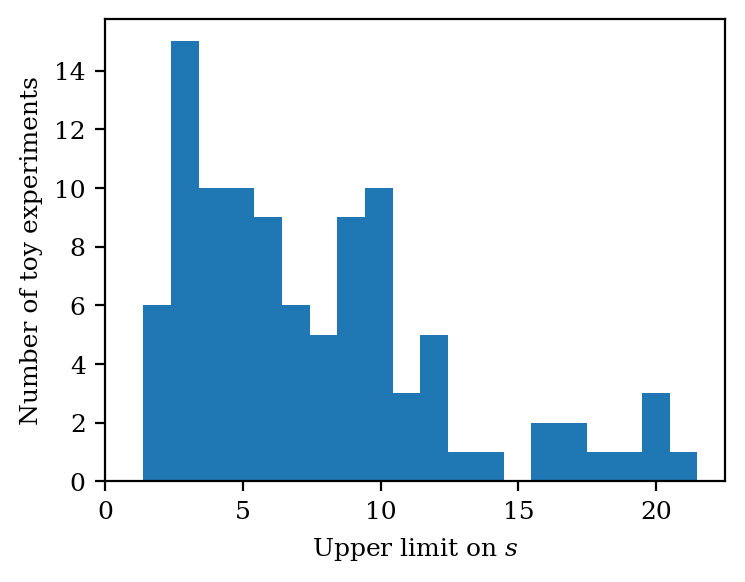

In [38]:
plt.hist(uls, bins=20)

plt.xlim(0)
plt.xlabel("Upper limit on $s$")
plt.ylabel("Number of toy experiments")

In [19]:
import pickle
with open('/home/yuanlq/software/light_wimp_data_release/light_wimp_data_release/data/real_data.pkl', 'rb') as f:
    real_data = pickle.load(f)

In [45]:
import alea
from alea.models import BlueiceExtendedModel
config_path = '/home/yuanlq/software/light_wimp_data_release/light_wimp_data_release/data/test_statistical_model.yaml'
config = alea.utils.load_yaml(config_path)
model = BlueiceExtendedModel(parameter_definition=config['parameter_definition'], 
                             likelihood_config=config['likelihood_config'],
                             confidence_level=0.9,
                             confidence_interval_kind='central',
                             template_path='/home/yuanlq/software/light_wimp_data_release/light_wimp_data_release/data/')
model.data = real_data

INFO:root:Load generated_dm/template_XENONnT_sr0_fermionic_dm_{wimp_mass:d}_tly_{t_ly:.1f}_tqy_{t_qy:.1f}.h5 successfully from /home/yuanlq/software/light_wimp_data_release/light_wimp_data_release/data/generated_dm/template_XENONnT_sr0_fermionic_dm_{wimp_mass:d}_tly_{t_ly:.1f}_tqy_{t_qy:.1f}.h5
INFO:root:Load generated_dm/template_XENONnT_sr0_fermionic_dm_{wimp_mass:d}_tly_{t_ly:.1f}_tqy_{t_qy:.1f}.h5 successfully from /home/yuanlq/software/light_wimp_data_release/light_wimp_data_release/data/generated_dm/template_XENONnT_sr0_fermionic_dm_{wimp_mass:d}_tly_{t_ly:.1f}_tqy_{t_qy:.1f}.h5
INFO:root:Load generated_b8/template_XENONnT_sr0_b8_6_tly_{t_ly:.1f}_tqy_{t_qy:.1f}.h5 successfully from /home/yuanlq/software/light_wimp_data_release/light_wimp_data_release/data/generated_b8/template_XENONnT_sr0_b8_6_tly_{t_ly:.1f}_tqy_{t_qy:.1f}.h5
INFO:root:Load generated_b8/template_XENONnT_sr0_b8_6_tly_{t_ly:.1f}_tqy_{t_qy:.1f}.h5 successfully from /home/yuanlq/software/light_wimp_data_release/light

In [47]:
# Just use asymptotic thr
best_fit, ll_free = model.fit()
null_fit, ll_zero = model.fit(wimp_rate_multiplier=0)
q0 = -2 * (ll_zero - ll_free)
dl, ul = model.confidence_interval(poi_name="wimp_rate_multiplier")

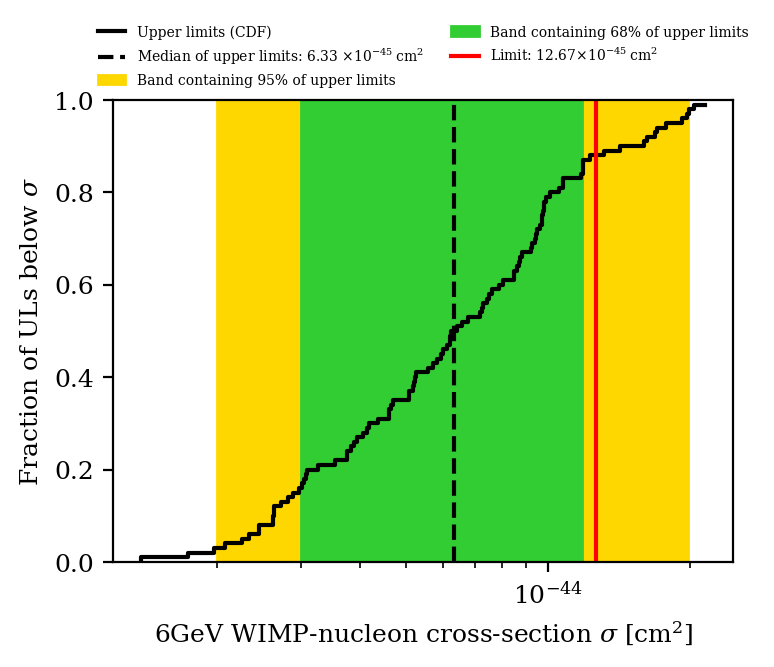

In [69]:
ref_xsec = 1e-45  # cm^2
uls_xsec = uls * ref_xsec
median_ul = np.quantile(uls_xsec, stats.norm().sf(0))

# plot CDF of upper limits
plt.figure(figsize=(4,3))
plt.step(
    np.sort(uls_xsec),
    np.linspace(0, 1, len(uls_xsec), endpoint=False),
    color="k",
    label="Upper limits (CDF)",
)

# plot median and bands
plt.axvline(
    median_ul,
    color="k",
    zorder=0,
    ls="--",
    label=rf"Median of upper limits: {median_ul*1e45:.2f} $\times 10^{{-45}}\;\mathrm{{cm}}^2$",
)
plt.axvspan(
    np.quantile(uls_xsec, stats.norm().sf(-2)),
    np.quantile(uls_xsec, stats.norm().sf(2)),
    color="gold",
    zorder=-2,
    label="Band containing 95% of upper limits",
)
plt.axvspan(
    np.quantile(uls_xsec, stats.norm().sf(-1)),
    np.quantile(uls_xsec, stats.norm().sf(1)),
    color="limegreen",
    zorder=-1,
    label="Band containing 68% of upper limits",
)

# limit
plt.axvline(ul * ref_xsec, color="red", label=rf"Limit: {ul:.2f}$\times 10^{{-45}}\;\mathrm{{cm}}^2$")

# Cosmetics
plt.legend(ncol=2, bbox_to_anchor=(0.5, 1), loc="lower center", fontsize=5, frameon=False)
plt.ylim(0, 1)
plt.semilogx()
plt.xlabel("6GeV WIMP-nucleon cross-section $\sigma$ [cm$^2$]")
plt.ylabel("Fraction of ULs below $\sigma$")
plt.savefig("test_result.svg")

# 5. Validation

In [70]:
# Build templates for DM
for tly in [-3, -2, -1, 0, 1, 2, 3]:
    for tqy in [-3, -2, -1, 0, 1, 2, 3]:
        _custom_yield_model = dict()
        # Example uncertainty: 0.5 quanta/kev
        _custom_template = template.build_template(wimp_spectrum)
        
        for sr in ['sr0', 'sr1']:
            fn = f"../light_wimp_data_release/data/generated_dm_vanilla/template_XENONnT_{sr}_fermionic_dm_6_tly_{tly}.0_tqy_{tqy}.0.h5" 
            multihist_to_template([_custom_template[sr]], fn, ['template'])

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13519 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13556 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13642 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13473 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13495 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13542 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13531 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13594 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13553 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13666 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13493 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13506 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13602 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13499 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13539 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13573 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13513 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13584 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13628 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13594 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13601 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13582 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13588 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13574 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13531 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13545 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13518 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13621 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13580 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13615 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13576 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13596 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13535 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13555 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13645 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13625 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13688 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13537 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13400 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13510 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13594 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13493 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13620 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13744 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13526 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13475 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13614 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13553 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13511 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13482 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13543 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13511 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13628 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13590 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13495 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13495 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13594 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13508 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13593 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13514 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13552 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13509 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13583 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13464 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13539 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13591 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13550 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13512 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13506 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13561 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13510 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13623 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13671 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13543 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13505 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13609 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13557 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13636 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13545 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13590 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13672 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13553 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13635 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13592 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13550 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13561 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13552 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13581 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13595 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13716 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13567 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13513 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13527 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13657 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13489 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13593 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13498 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13609 [00:00<?, ?it/s]

In [10]:
file_path = "../light_wimp_data_release/data/test_statistical_model_vanilla.yaml"
model_config = load_yaml(file_path)

In [11]:
runner = Runner(
    statistical_model="alea.models.blueice_extended_model.BlueiceExtendedModel",
    poi="wimp_rate_multiplier",
    hypotheses=["free"],
    n_mc=100,
    generate_values={"wimp_rate_multiplier": 0.0},
    compute_confidence_interval=True,
    toydata_mode="generate",
    output_filename="out_vanilla.ii.h5",
    **model_config
)

INFO:root:Load generated_dm_vanilla/template_XENONnT_sr0_fermionic_dm_{wimp_mass:d}_tly_{t_ly:.1f}_tqy_{t_qy:.1f}.h5 successfully from /home/yuanlq/software/light_wimp_data_release/light_wimp_data_release/data/generated_dm_vanilla/template_XENONnT_sr0_fermionic_dm_{wimp_mass:d}_tly_{t_ly:.1f}_tqy_{t_qy:.1f}.h5
INFO:root:Load generated_dm_vanilla/template_XENONnT_sr0_fermionic_dm_{wimp_mass:d}_tly_{t_ly:.1f}_tqy_{t_qy:.1f}.h5 successfully from /home/yuanlq/software/light_wimp_data_release/light_wimp_data_release/data/generated_dm_vanilla/template_XENONnT_sr0_fermionic_dm_{wimp_mass:d}_tly_{t_ly:.1f}_tqy_{t_qy:.1f}.h5
INFO:root:Load b8/template_XENONnT_sr0_b8_cevns_tly_{t_ly:.1f}_tqy_{t_qy:.1f}.h5 successfully from /home/yuanlq/software/light_wimp_data_release/light_wimp_data_release/data/b8/template_XENONnT_sr0_b8_cevns_tly_{t_ly:.1f}_tqy_{t_qy:.1f}.h5
INFO:root:Load b8/template_XENONnT_sr0_b8_cevns_tly_{t_ly:.1f}_tqy_{t_qy:.1f}.h5 successfully from /home/yuanlq/software/light_wimp_data

In [73]:
results = runner.run()

100%|██████████| 100/100 [25:54<00:00, 15.55s/it]

Saving out_vanilla.ii.h5
Used real time 1554.60s, CPU time 1546.63s


In [12]:
results = toyfiles_to_numpy("out_vanilla.ii.h5")
uls = results["free"]["ul"]

In [20]:
import alea
from alea.models import BlueiceExtendedModel
config_path = '/home/yuanlq/software/light_wimp_data_release/light_wimp_data_release/data/test_statistical_model_vanilla.yaml'
config = alea.utils.load_yaml(config_path)
model = BlueiceExtendedModel(parameter_definition=config['parameter_definition'], 
                             likelihood_config=config['likelihood_config'],
                             confidence_level=0.9,
                             confidence_interval_kind='central',
                             template_path='/home/yuanlq/software/light_wimp_data_release/light_wimp_data_release/data/')
model.data = real_data

INFO:root:Load generated_dm_vanilla/template_XENONnT_sr0_fermionic_dm_{wimp_mass:d}_tly_{t_ly:.1f}_tqy_{t_qy:.1f}.h5 successfully from /home/yuanlq/software/light_wimp_data_release/light_wimp_data_release/data/generated_dm_vanilla/template_XENONnT_sr0_fermionic_dm_{wimp_mass:d}_tly_{t_ly:.1f}_tqy_{t_qy:.1f}.h5
INFO:root:Load generated_dm_vanilla/template_XENONnT_sr0_fermionic_dm_{wimp_mass:d}_tly_{t_ly:.1f}_tqy_{t_qy:.1f}.h5 successfully from /home/yuanlq/software/light_wimp_data_release/light_wimp_data_release/data/generated_dm_vanilla/template_XENONnT_sr0_fermionic_dm_{wimp_mass:d}_tly_{t_ly:.1f}_tqy_{t_qy:.1f}.h5
INFO:root:Load b8/template_XENONnT_sr0_b8_cevns_tly_{t_ly:.1f}_tqy_{t_qy:.1f}.h5 successfully from /home/yuanlq/software/light_wimp_data_release/light_wimp_data_release/data/b8/template_XENONnT_sr0_b8_cevns_tly_{t_ly:.1f}_tqy_{t_qy:.1f}.h5
INFO:root:Load b8/template_XENONnT_sr0_b8_cevns_tly_{t_ly:.1f}_tqy_{t_qy:.1f}.h5 successfully from /home/yuanlq/software/light_wimp_data

In [21]:
# Just use asymptotic thr
best_fit, ll_free = model.fit()
null_fit, ll_zero = model.fit(wimp_rate_multiplier=0)
q0 = -2 * (ll_zero - ll_free)
dl, ul = model.confidence_interval(poi_name="wimp_rate_multiplier")

Text(0, 0.5, 'Fraction of ULs below $\\sigma$')

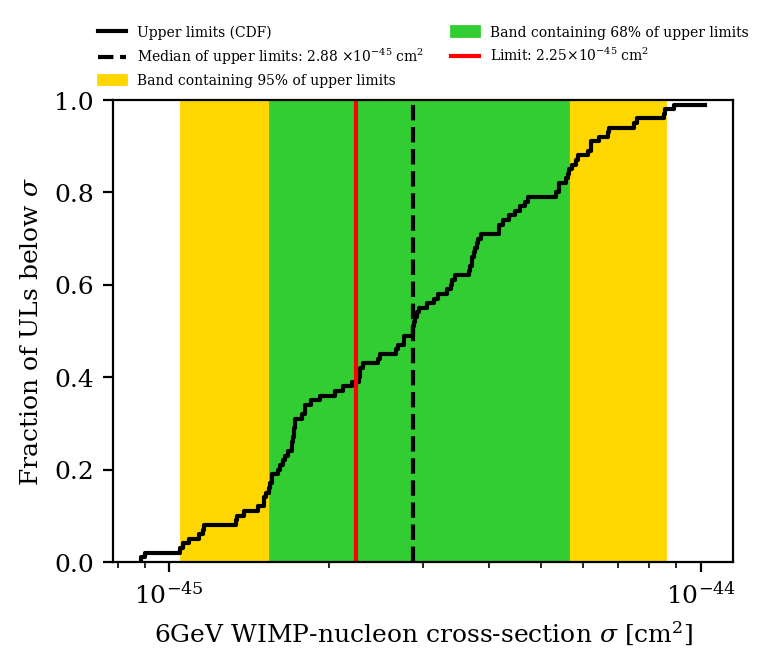

In [22]:
ref_xsec = 1e-45  # cm^2
uls_xsec = uls * ref_xsec
median_ul = np.quantile(uls_xsec, stats.norm().sf(0))

# plot CDF of upper limits
plt.figure(figsize=(4,3))
plt.step(
    np.sort(uls_xsec),
    np.linspace(0, 1, len(uls_xsec), endpoint=False),
    color="k",
    label="Upper limits (CDF)",
)

# plot median and bands
plt.axvline(
    median_ul,
    color="k",
    zorder=0,
    ls="--",
    label=rf"Median of upper limits: {median_ul*1e45:.2f} $\times 10^{{-45}}\;\mathrm{{cm}}^2$",
)
plt.axvspan(
    np.quantile(uls_xsec, stats.norm().sf(-2)),
    np.quantile(uls_xsec, stats.norm().sf(2)),
    color="gold",
    zorder=-2,
    label="Band containing 95% of upper limits",
)
plt.axvspan(
    np.quantile(uls_xsec, stats.norm().sf(-1)),
    np.quantile(uls_xsec, stats.norm().sf(1)),
    color="limegreen",
    zorder=-1,
    label="Band containing 68% of upper limits",
)

# limit
plt.axvline(ul * ref_xsec, color="red", label=rf"Limit: {ul:.2f}$\times 10^{{-45}}\;\mathrm{{cm}}^2$")

# Cosmetics
plt.legend(ncol=2, bbox_to_anchor=(0.5, 1), loc="lower center", fontsize=5, frameon=False)
plt.ylim(0, 1)
plt.semilogx()
plt.xlabel("6GeV WIMP-nucleon cross-section $\sigma$ [cm$^2$]")
plt.ylabel("Fraction of ULs below $\sigma$")


In [23]:
rigorous_limit=np.load("/home/yuanlq/software/LightWIMP/Data/new_limit/xenonnt_si_limit_before_pcl.npy")['limit_cm2'][3]

In [24]:
rigorous_limit

2.5323839509210373e-45

In [25]:
import pandas as pd
rigorous_sensi = pd.read_csv("/home/yuanlq/software/LightWIMP/Data/new_limit/XENONnT_SR0+1_light_WIMP_v11_as_cevns_si_1.17_2.34.csv").iloc[3]

In [26]:
rigorous_sensi

Unnamed: 0    3.000000e+00
median        3.703263e-45
2ul           1.558444e-44
ul            7.911805e-45
dl            1.501609e-45
2dl           7.050602e-46
wimp_mass     6.000000e+00
Name: 3, dtype: float64

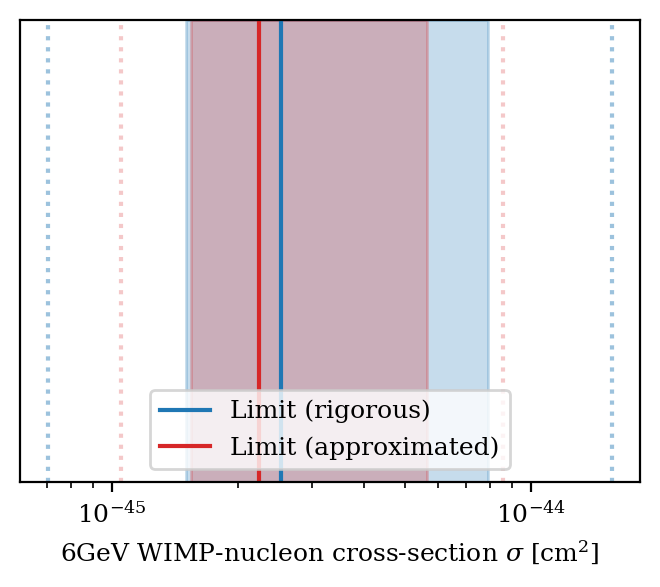

In [37]:
#plt.axvspan(rigorous_sensi['median'], rigorous_sensi['dl'], color="tab:blue", alpha=0.25)
plt.figure()
plt.axvline(rigorous_sensi['2dl'], color="tab:blue", alpha=0.25, ls=":")
plt.axvline(rigorous_sensi['2ul'], color="tab:blue", alpha=0.25, ls=":")
plt.axvspan(rigorous_sensi['dl'], rigorous_sensi['ul'], color="tab:blue", alpha=0.25)
#plt.axvspan(rigorous_sensi['median'], rigorous_sensi['dl'], color="tab:blue", alpha=0.25)
plt.axvline(rigorous_sensi['2dl'], color="tab:blue", alpha=0.25, ls=":")
plt.axvline(rigorous_sensi['2ul'], color="tab:blue", alpha=0.25, ls=":")
plt.axvline(rigorous_limit, color="tab:blue", label="Limit (rigorous)")

plt.axvline(np.quantile(uls_xsec, stats.norm().sf(-2)), 
            color="tab:red", alpha=0.25, ls=":")
plt.axvline(np.quantile(uls_xsec, stats.norm().sf(2)), 
            color="tab:red", alpha=0.25, ls=":")
plt.axvspan(np.quantile(uls_xsec, stats.norm().sf(-1)), np.quantile(uls_xsec, stats.norm().sf(1)),
            color="tab:red", alpha=0.25)
plt.axvline(ul * ref_xsec, color="tab:red", label="Limit (approximated)")


plt.ylim(0, 1)
plt.semilogx()
plt.xlabel("6GeV WIMP-nucleon cross-section $\sigma$ [cm$^2$]")
#plt.ylabel("Fraction of ULs below $\sigma$")
plt.legend()
plt.yticks([])
plt.savefig("examined_6GeV.svg")


## Limit ratio

In [8]:
# Build templates for DM
for wm in [3,4,5,6,8,10,12]:
    _wimp_spectrum = load_json(path + f"signal/wimp_si_spectrum_{wm}.json")
    for tly in [-3, -2, -1, 0, 1, 2, 3]:
        for tqy in [-3, -2, -1, 0, 1, 2, 3]:
            _custom_yield_model = dict()
            # Example uncertainty: 0.5 quanta/kev
            _custom_template = template.build_template(_wimp_spectrum)
            
            for sr in ['sr0', 'sr1']:
                fn = f"../light_wimp_data_release/data/generated_dm_vanilla/template_XENONnT_{sr}_fermionic_dm_{wm}_tly_{tly}.0_tqy_{tqy}.0.h5" 
                multihist_to_template([_custom_template[sr]], fn, ['template'])

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3268 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3265 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3219 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3223 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3294 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3202 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3275 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3151 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3309 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3283 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3236 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3388 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3178 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3346 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3277 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3217 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3348 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3194 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3305 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3267 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3140 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3297 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3340 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3259 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3256 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3148 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3181 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3209 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3245 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3308 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3227 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3253 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3270 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3222 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3295 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3200 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3331 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3253 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3122 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3227 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3279 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3195 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3277 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3230 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3265 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3229 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3283 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3254 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3315 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3226 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3167 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3302 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3286 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3206 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3231 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3213 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3228 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3152 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3363 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3247 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3245 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3213 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3243 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3299 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3216 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3216 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3233 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3196 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3262 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3310 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3167 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3197 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3108 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3228 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3292 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3174 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3225 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3188 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3209 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3197 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3260 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3254 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3310 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3271 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3111 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3203 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3269 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3189 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3232 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3299 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3149 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3222 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3354 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3181 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3232 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3209 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3160 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3192 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8124 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8134 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8024 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8151 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8013 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8036 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7946 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7992 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7917 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7904 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7892 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8059 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8005 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7978 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7998 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8015 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7962 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8080 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7957 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8161 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8018 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8041 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7950 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8054 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8050 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7956 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8137 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8019 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7922 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7945 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7939 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8109 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7996 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8013 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8013 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8118 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7927 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8001 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8031 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8103 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7893 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7976 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8006 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8116 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8014 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7899 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7966 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8010 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7993 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8027 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8125 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7920 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7893 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8026 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8038 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8052 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8013 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7954 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7860 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8009 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7916 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8005 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8004 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8174 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8045 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8061 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8153 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7903 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8094 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7930 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7972 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8119 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7900 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8035 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8115 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7987 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8022 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7941 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7948 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8076 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7861 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8123 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8097 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8002 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8048 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8094 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8057 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8003 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7967 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/8089 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7931 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7973 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7928 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7978 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7939 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7890 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7929 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/7945 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11261 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11499 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11319 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11398 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11247 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11296 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11219 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11338 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11253 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11316 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11280 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11407 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11443 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11391 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11349 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11377 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11385 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11438 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11335 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11331 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11353 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11263 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11352 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11226 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11293 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11373 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11345 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11406 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11467 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11405 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11351 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11369 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11290 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11284 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11355 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11348 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11300 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11447 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11467 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11416 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11395 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11275 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11297 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11389 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11446 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11256 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11218 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11359 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11421 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11336 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11270 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11209 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11333 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11423 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11353 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11363 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11376 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11320 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11440 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11303 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11426 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11323 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11430 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11353 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11335 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11293 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11276 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11358 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11456 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11344 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11342 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11433 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11361 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11348 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11378 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11403 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11310 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11352 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11339 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11325 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11353 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11381 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11436 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11362 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11300 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11280 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11405 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11298 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11314 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11348 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11457 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11457 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11313 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11346 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11402 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11255 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11467 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/11342 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13616 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13565 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13582 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13610 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13695 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13577 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13561 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13641 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13513 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13652 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13434 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13525 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13566 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13611 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13511 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13564 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13523 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13558 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13593 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13562 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13495 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13478 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13639 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13619 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13539 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13492 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13623 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13537 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13660 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13572 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13476 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13562 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13663 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13530 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13537 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13569 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13607 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13445 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13705 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13599 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13590 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13562 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13586 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13629 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13489 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13642 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13537 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13567 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13476 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13457 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13497 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13598 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13584 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13495 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13515 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13591 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13608 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13489 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13537 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13486 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13587 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13674 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13518 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13446 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13361 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13587 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13640 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13580 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13572 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13653 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13493 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13560 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13575 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13582 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13677 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13452 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13655 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13641 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13588 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13527 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13623 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13610 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13545 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13481 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13544 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13610 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13622 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13697 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13561 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13617 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13510 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13543 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13576 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13553 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13633 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13569 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13584 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/13579 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16061 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/15986 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16061 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16058 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16086 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/15930 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16020 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16027 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/15963 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16008 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/15985 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16030 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16050 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16040 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16057 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16002 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16013 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/15918 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/15882 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16001 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16071 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/15943 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/15938 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/15975 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16017 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/15982 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16094 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16126 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/15940 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16067 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/15995 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/15972 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16024 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16043 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/15979 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/15930 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/15995 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/15968 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/15965 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16000 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/15974 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16077 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/15935 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16099 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16043 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16044 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16038 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16056 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16021 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/15964 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16129 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16022 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16037 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/15948 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/15986 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16193 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16029 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/15990 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16002 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/15986 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16028 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/15991 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16042 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/15976 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16069 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16098 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16088 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/15992 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16044 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16080 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16034 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16024 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16077 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/15995 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16089 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16017 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16128 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16054 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16029 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/15954 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/15938 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/15998 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/15924 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16070 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/15984 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16119 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/15996 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16024 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16057 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16140 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16139 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16057 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/15961 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16004 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16086 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/15950 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/16081 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/15954 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17183 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17187 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17206 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17146 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17167 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17284 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17250 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17195 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17208 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17089 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17195 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17160 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17270 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17164 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17252 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17161 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17190 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17319 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17272 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17190 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17252 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17290 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17178 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17167 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17180 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17210 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17252 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17203 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17295 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17146 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17246 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17310 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17249 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17137 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17214 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17242 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17217 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17230 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17193 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17250 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17206 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17268 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17261 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17228 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17254 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17107 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17233 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17260 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17220 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17240 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17230 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17261 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17277 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17302 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17293 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17219 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17199 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17276 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17208 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17211 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17223 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17113 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17265 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17184 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17183 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17219 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17241 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17246 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17190 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17203 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17233 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17182 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17311 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17196 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17276 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17269 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17227 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17240 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17202 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17186 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17266 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17124 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17191 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17214 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17163 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17251 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17153 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17285 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17211 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17188 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17116 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17210 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17321 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17314 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17215 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17159 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17180 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17148 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17817 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17761 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17855 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17818 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17827 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17914 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17862 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17829 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17804 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17811 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17808 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17854 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17827 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17815 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17857 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17831 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17833 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17834 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17765 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17829 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17827 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17865 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17744 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17816 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17845 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17804 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17863 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17810 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17835 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17905 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17857 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17806 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17883 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17831 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17792 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17868 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17851 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17865 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17817 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17865 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17833 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17827 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17905 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17861 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17793 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17839 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17864 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17882 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17803 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17847 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17826 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17854 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17803 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17863 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17826 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17743 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17816 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17777 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17878 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17846 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17859 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17850 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17786 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17829 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17840 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17765 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17811 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17848 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17841 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17815 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17850 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17828 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17886 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17762 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17828 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17825 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17795 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17816 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17833 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17773 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17803 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17890 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17857 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17791 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17871 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17806 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17838 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17902 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17891 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17850 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17804 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17783 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17917 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17852 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17802 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17808 [00:00<?, ?it/s]

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17878 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/17844 [00:00<?, ?it/s]

In [11]:
import alea
from alea.models import BlueiceExtendedModel

models = dict()
wimp_masses = [3, 4, 5, 6, 8, 10, 12]
config_path = "../light_wimp_data_release/data/test_statistical_model_vanilla.yaml"
template_path = "../light_wimp_data_release/data/generated_dm_vanilla/"

for wimp_mass in wimp_masses:    
    config = alea.utils.load_yaml(config_path)
    config['parameter_definition']['wimp_mass']['nominal_value'] = wimp_mass
    model = BlueiceExtendedModel(parameter_definition=config['parameter_definition'], 
                                 likelihood_config=config['likelihood_config'],
                                 confidence_level=0.9,
                                 confidence_interval_kind='central',
                                 template_path=template_path)
    models[wimp_mass] = model

INFO:root:Load generated_dm_vanilla/template_XENONnT_sr0_fermionic_dm_{wimp_mass:d}_tly_{t_ly:.1f}_tqy_{t_qy:.1f}.h5 successfully from /home/yuanlq/software/light_wimp_data_release/light_wimp_data_release/data/generated_dm_vanilla/template_XENONnT_sr0_fermionic_dm_{wimp_mass:d}_tly_{t_ly:.1f}_tqy_{t_qy:.1f}.h5
INFO:root:Load generated_dm_vanilla/template_XENONnT_sr0_fermionic_dm_{wimp_mass:d}_tly_{t_ly:.1f}_tqy_{t_qy:.1f}.h5 successfully from /home/yuanlq/software/light_wimp_data_release/light_wimp_data_release/data/generated_dm_vanilla/template_XENONnT_sr0_fermionic_dm_{wimp_mass:d}_tly_{t_ly:.1f}_tqy_{t_qy:.1f}.h5
INFO:root:Load b8/template_XENONnT_sr0_b8_cevns_tly_{t_ly:.1f}_tqy_{t_qy:.1f}.h5 successfully from /home/yuanlq/software/light_wimp_data_release/light_wimp_data_release/data/b8/template_XENONnT_sr0_b8_cevns_tly_{t_ly:.1f}_tqy_{t_qy:.1f}.h5
INFO:root:Load b8/template_XENONnT_sr0_b8_cevns_tly_{t_ly:.1f}_tqy_{t_qy:.1f}.h5 successfully from /home/yuanlq/software/light_wimp_data

NameError: name 'USE_TOY_DATA' is not defined

In [16]:
import inference_interface
import pickle
with open('/home/yuanlq/software/light_wimp_data_release/light_wimp_data_release/data/real_data.pkl', 'rb') as f:
    real_data = pickle.load(f)

for wimp_mass in wimp_masses:
    models[wimp_mass].data = real_data

/home/yuanlq/.local/lib/python3.9/site-packages/alea/models/blueice_extended_model.py:108: UserWarning: If data is not a list of length 4, only the science data and ancillary will be set.
  warnings.warn(
/home/yuanlq/.local/lib/python3.9/site-packages/alea/models/blueice_extended_model.py:108: UserWarning: If data is not a list of length 4, only the science data and ancillary will be set.
  warnings.warn(
/home/yuanlq/.local/lib/python3.9/site-packages/alea/models/blueice_extended_model.py:108: UserWarning: If data is not a list of length 4, only the science data and ancillary will be set.
  warnings.warn(
/home/yuanlq/.local/lib/python3.9/site-packages/alea/models/blueice_extended_model.py:108: UserWarning: If data is not a list of length 4, only the science data and ancillary will be set.
  warnings.warn(
/home/yuanlq/.local/lib/python3.9/site-packages/alea/models/blueice_extended_model.py:108: UserWarning: If data is not a list of length 4, only the science data and ancillary will 

In [17]:
dls = []
uls = []
for wm in tqdm(wimp_masses):
    model = models[wm]
    best_fit, ll_free = model.fit()
    null_fit, ll_zero = model.fit(wimp_rate_multiplier=0)
    q0 = -2 * (ll_zero - ll_free)
    dl, ul = model.confidence_interval(poi_name="wimp_rate_multiplier")
    uls.append(ul)
    dls.append(dl)
dls = np.array(dls)
uls = np.array(uls)

100%|██████████| 7/7 [01:25<00:00, 12.26s/it]


In [20]:
nominal_cross_section = 1e-45
dls *= nominal_cross_section
uls *= nominal_cross_section

In [23]:
rigorous_limit=np.load("/home/yuanlq/software/LightWIMP/Data/new_limit/xenonnt_si_limit_before_pcl.npy")['limit_cm2']

Text(0, 0.5, 'Recasted / Rigorous Limit before PCL')

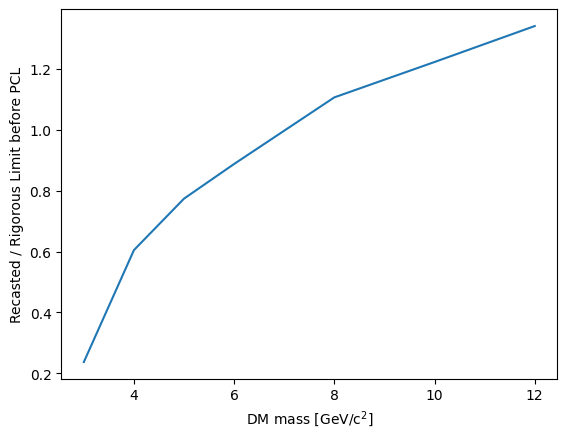

In [28]:
plt.plot(wimp_masses, uls/rigorous_limit)
plt.xlabel("DM mass [GeV/c$^2$]")
plt.ylabel("Recasted / Rigorous Limit before PCL")
plt.savefig("")